In [185]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import PIL
import PIL.Image
import keras

from tensorflow.keras.preprocessing import image_dataset_from_directory

print(tf.__version__)

2.3.1


In [186]:
print(keras.__version__)

2.3.0


In [187]:
data_dir = "/Users/maanitsharma/Desktop/Grape_research/fogarty_classification/forgarty_data_date/f_purple_grape_models/fpFullSeasonM1/"
CATEGORIES = ['pPhase1', 'pPhase2', 'pPhase3', 'pPhase4']

In [188]:
batch_size = 32
img_height = 224
img_width = 224

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 830 files belonging to 4 classes.
Using 664 files for training.


In [189]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 830 files belonging to 4 classes.
Using 166 files for validation.


In [190]:
class_names = train_dataset.class_names
print(class_names)
print(train_dataset)

['pPhase1', 'pPhase2', 'pPhase3', 'pPhase4']
<BatchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.float32)>


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [191]:
print(class_names[np.where(labels[1]==1)[0][0]])

pPhase4


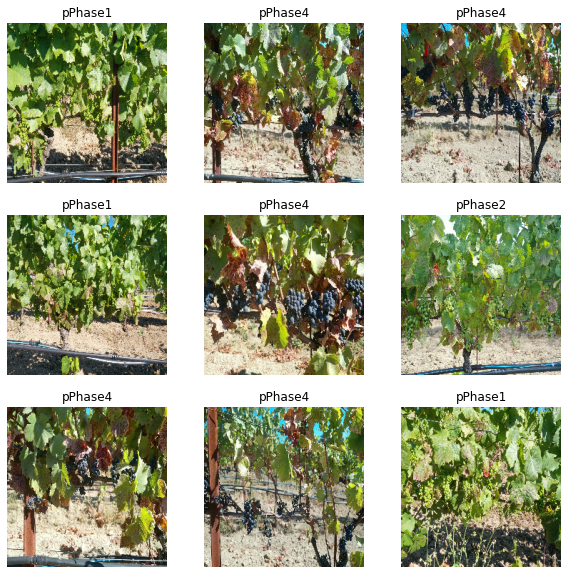

In [192]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.where(labels[i]==1)[0][0]])
    plt.axis("off")

In [193]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
#Validation dataset has 2 batches that contain 32 images
test_dataset = validation_dataset.take(val_batches // 2) #We take 33% of the validation batches, the fist half, and use this as our test dataset

validation_dataset = validation_dataset.skip(val_batches // 2) #We take the other half, second batch, and this is our validation dataset.
 
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 3
Number of test batches: 3


In [194]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [195]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

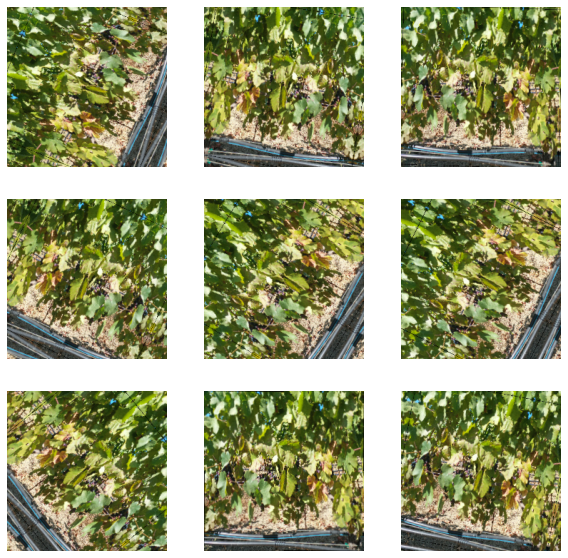

In [196]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [197]:
#Rescale pixel values of images from [0,255] to [-1,1] as resnet takes images with pixel values in the range [-1,1]
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [198]:
#Create base ResNet50 model with pretrained weights on imagenet dataset.
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                include_top=False,
                                               weights='imagenet')

In [199]:
# Convert each 224x224x3 image into a 7x7x2048 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [200]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [201]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [202]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
#For binary classification #prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [203]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [204]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_4  [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_4 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)             

In [205]:
len(model.trainable_variables)

2

In [206]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 1s 366ms/step - loss: 1.6322 - accuracy: 0.3429


In [207]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.63
initial accuracy: 0.34


In [208]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
21/21 [==============================] - 83s 4s/step - loss: 1.5862 - accuracy: 0.3419 - val_loss: 1.3276 - val_accuracy: 0.4714
Epoch 2/10
21/21 [==============================] - 81s 4s/step - loss: 1.3036 - accuracy: 0.4518 - val_loss: 1.2634 - val_accuracy: 0.4000
Epoch 3/10
21/21 [==============================] - 81s 4s/step - loss: 1.1512 - accuracy: 0.5000 - val_loss: 0.8746 - val_accuracy: 0.6571
Epoch 4/10
21/21 [==============================] - 296s 14s/step - loss: 1.0044 - accuracy: 0.6009 - val_loss: 0.8084 - val_accuracy: 0.6571
Epoch 5/10
21/21 [==============================] - 80s 4s/step - loss: 0.8656 - accuracy: 0.6521 - val_loss: 0.7491 - val_accuracy: 0.7429
Epoch 6/10
21/21 [==============================] - 83s 4s/step - loss: 0.7935 - accuracy: 0.6973 - val_loss: 0.6014 - val_accuracy: 0.7857
Epoch 7/10
21/21 [==============================] - 80s 4s/step - loss: 0.7135 - accuracy: 0.7425 - val_loss: 0.6214 - val_accuracy: 0.8000
Epoch 8/10
21/21 [

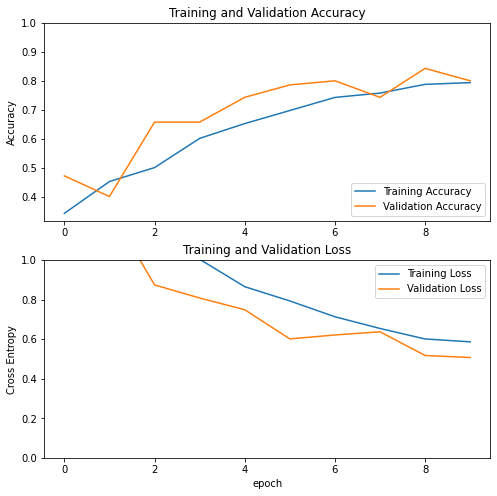

In [209]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [210]:
base_model.trainable = True

In [211]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [212]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_4  [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_4 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)             

In [213]:
len(model.trainable_variables)

92

In [214]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
21/21 [==============================] - 276s 13s/step - loss: 0.3605 - accuracy: 0.8675 - val_loss: 0.2014 - val_accuracy: 0.9143
Epoch 11/20
21/21 [==============================] - 275s 13s/step - loss: 0.1388 - accuracy: 0.9563 - val_loss: 0.1621 - val_accuracy: 0.9429
Epoch 12/20
21/21 [==============================] - 276s 13s/step - loss: 0.1050 - accuracy: 0.9623 - val_loss: 0.1618 - val_accuracy: 0.9429
Epoch 13/20
21/21 [==============================] - 275s 13s/step - loss: 0.0718 - accuracy: 0.9714 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 14/20
21/21 [==============================] - 282s 13s/step - loss: 0.0480 - accuracy: 0.9789 - val_loss: 0.0600 - val_accuracy: 0.9714
Epoch 15/20
21/21 [==============================] - 255s 12s/step - loss: 0.0385 - accuracy: 0.9864 - val_loss: 0.0456 - val_accuracy: 0.9714
Epoch 16/20
21/21 [==============================] - 229s 11s/step - loss: 0.0281 - accuracy: 0.9910 - val_loss: 0.0168 - val_accuracy: 1.0000

In [215]:
model.save("PurpleModelV1June8.h5")

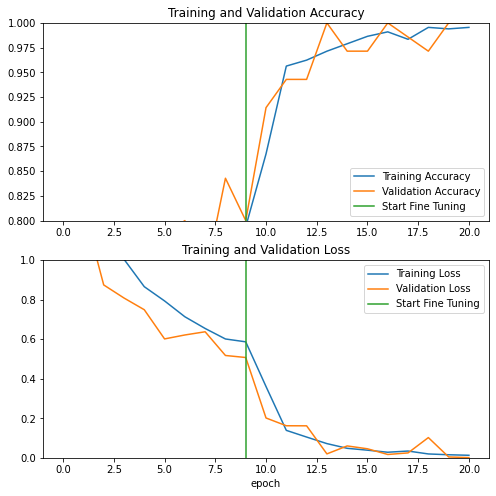

In [216]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [217]:
len(test_dataset)

3

In [218]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 2s 648ms/step - loss: 0.0059 - accuracy: 1.0000
Test accuracy : 1.0


In [219]:
loss, accuracy = model.evaluate(validation_dataset)
print('Validation accuracy :', accuracy)

3/3 [==============================] - 1s 396ms/step - loss: 7.7659e-04 - accuracy: 1.0000
Validation accuracy : 1.0


In [220]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.nn.softmax(predictions)
predictions = np.argmax(predictions, axis=-1)
print('Predictions:\n', predictions)
print('Labels:\n', np.argmax(label_batch, axis=-1))

Predictions:
 [2 0 0 0 1 3 0 0 3 2 2 2 2 3 3 0 3 2 2 0 3 0 0 3 3 3 3 0 2 0 2 3]
Labels:
 [2 0 0 0 1 3 0 0 3 2 2 2 2 3 3 0 3 2 2 0 3 0 0 3 3 3 3 0 2 0 2 3]


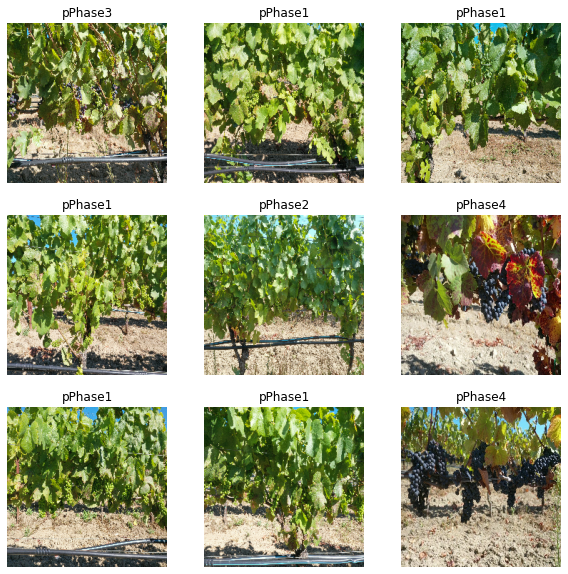

In [221]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")